# 5. Positional embedding and self-attention

In this document, we continue with text classification. Let us use the same data (movie reviews and IMDB database) as before; this time, we access the data directly from Keras: 

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import pad_sequences 

max_features = 10000 # vocabulary size
max_len = 250 # words per sample 

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) 

# pad all samples to same length 
x_train = pad_sequences(x_train, maxlen=max_len, padding='post') 
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

The downloaded samples have already been tokenized, and converted to integer lists of token indices; we have also padded them to have the same length. For later use, we build dictionaries to convert the integer indices in the sample lists to the corresponding words, and back. Note that the first three indices have special meanings: (0: padding, 1: sequence start, 2: unknown word).

In [2]:
word_to_index = imdb.get_word_index()
index_to_word = dict((value, key) for (key, value) in word_to_index.items())

example_review = " ".join(index_to_word.get(i-3, "?") for i in x_train[0])
print(example_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## Positional embedding

The next step is to convert the tokenized samples into word vectors. So far we have only considered simple fully connected network layers to process the vectorized text data. The obvious deficiency of such an approach is that it does not take the order of words in the sequence into account: Dense layers process the entire sequence as a whole. In a simple sentiment analysis task this might be quite satisfactory, but would lead to difficulties with more challenging problems (machine translation, text generation etc.).

In order to solve this problem, we need a method to inject some information about the order of words into the word vectors for the tokens. For this purpose, we define a custom layer that consists of two embedding layers: one for word tokens with shape (vocabulary size, embedding dimension), and one for position in the sample with shape (sample length, embedding dimension). Both of these layers are initialized randomly, and their tensor elements are treated as trainable parameters. The final embedding is then obtained by summing these two vectors, and the output shape of the custom embedding layer is (batch size, sample length, embedding dimension).

In [3]:
from tensorflow.keras.layers import Layer, Embedding
import tensorflow as tf

class TokenAndPositionEmbedding(Layer):
    def __init__(self, seq_len, vocab_size, emb_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=emb_dim)
        self.pos_emb = Embedding(input_dim=seq_len, output_dim=emb_dim)

    def call(self, x_input):
        seq_len = tf.shape(x_input)[-1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positions = self.pos_emb(positions)
        x_input = self.token_emb(x_input)
        return x_input + positions


Now we can create a classification model with the new order-sensitive embedding layer. The pooling layer is added to flatten the vectorized sequences; we also include a Dropout layer to reduce overfitting.

In [4]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Dropout 
from tensorflow.keras.models import Model 

embed_dim = 32 # word embeddings dimension 

inputs = Input(shape=(max_len,)) 
x = TokenAndPositionEmbedding(max_len, max_features, embed_dim)(inputs) 
x = GlobalAveragePooling1D()(x) 
x = Dropout(0.5)(x) 
outputs = Dense(1, activation='sigmoid')(x) 
model = Model(inputs=inputs, outputs=outputs) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 250, 32)        │       328,000 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,033 (1.25 MB)

 Trainable params: 328,033 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

Let us train this model ...

In [5]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6041 - loss: 0.6728
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7828 - loss: 0.5269
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8460 - loss: 0.3995
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8712 - loss: 0.3350
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8865 - loss: 0.2975
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8961 - loss: 0.2755
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9021 - loss: 0.2554
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9090 - loss: 0.2403
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9165 - loss: 0.2257
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9199 - loss: 0.2104


... and test it.

In [6]:
print(f'Test accuracy = {model.evaluate(x_test, y_test)[1]:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8874 - loss: 0.2793
Test accuracy = 0.8853


## Self-attention

Natural language processing has been revolutionized by the Transformer architecture. A central ingredient in these kinds of neural networks is the concept of **attention**, see [the original publication](https://arxiv.org/abs/1706.03762). 

The attention mechanism can be seen as a way to modify the vector representation of words (or tokens) by the other words in the sequence. Each word in the sequence is thought to present a **query**, to which the other words respond to: the words are also associated with **keys** and **values** to characterize them. The relevance of other words in connection with the target word is determined by comparing their keys against the query, and the resulting attention scores are used to weight the values, and to compute a refined vector representation for the target word. These new and improved word embeddings provide additional insight into context and semantic meaning.

Keras provides a special `MultiHeadAttention` layer for the purpose of including attention to text processing models. When the tensors from the embedding layer are inserted into the attention layer, its output is a more context-aware version (with the same shape) of the original embeddings. The "heads" refer to the usual practice of dividing the vector processing to smaller-sized subspaces, that are processed parallel to each other, and concatenated back to the original shape in the end. The code cell below shows an example model with an attention layer.

In [7]:
from tensorflow.keras.layers import MultiHeadAttention 

num_heads = 2 # number of attention heads 

inputs = Input(shape=(max_len,)) 
x = TokenAndPositionEmbedding(max_len, max_features, embed_dim)(inputs) 
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x) 
x = GlobalAveragePooling1D()(attention_output) 
x = Dropout(0.5)(x) 
outputs = Dense(1, activation='sigmoid')(x) 
att_model = Model(inputs=inputs, outputs=outputs) 

att_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

att_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 250, 32)   │    328,000 │ input_layer_1[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 32)   │      8,416 │ token_and_positi… │
│ (MultiHeadAttentio… │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 336,449 (1.28 MB)

 Trainable params: 336,449 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Train the attention model ...


In [8]:
att_model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.6589 - loss: 0.5636
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8928 - loss: 0.2633
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9189 - loss: 0.2089
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9353 - loss: 0.1736
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9480 - loss: 0.1430


... and test it.

In [9]:
print(f'Test accuracy = {att_model.evaluate(x_test, y_test)[1]:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8706 - loss: 0.3754
Test accuracy = 0.8667


To gain some understanding about the workings of the attention mechanism, we note that it is possible to get access to the attention scores computed by the attention layer. First, we build yet another model for returning the outputs of the MultiHeadAttention layer, and set the argument `return_attention_scores` to True.

In [10]:
# Create a model for outputting attention scores

inps = att_model.input
embedding_output = att_model.layers[1](inps)
att_output, att_scores = att_model.layers[2](embedding_output, embedding_output, return_attention_scores=True)
score_model = Model(inputs=inps, outputs=[att_output, att_scores])

We insert the first training sample (batch of size 1) to this model, and store its attention scores that are output by the attention layer. We then extract the scores for a single self-attention head for inspection.

In [11]:
sample_input = x_train[:1]  # a single training example
_, attention_scores_all = score_model.predict(sample_input)

# scores for a single attention head
head_index = 0
attention_scores = attention_scores_all[0][head_index] 

# Verify the shape of attention scores
print(f"Attention scores, full shape: {attention_scores_all.shape}")
print(f"Attention scores, one head: {attention_scores.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Attention scores, full shape: (1, 2, 250, 250)
Attention scores, one head: (250, 250)


Now we can visualize the attention scores as a heatmap; you'll need to install the seaborn data visualization library for this purpose.

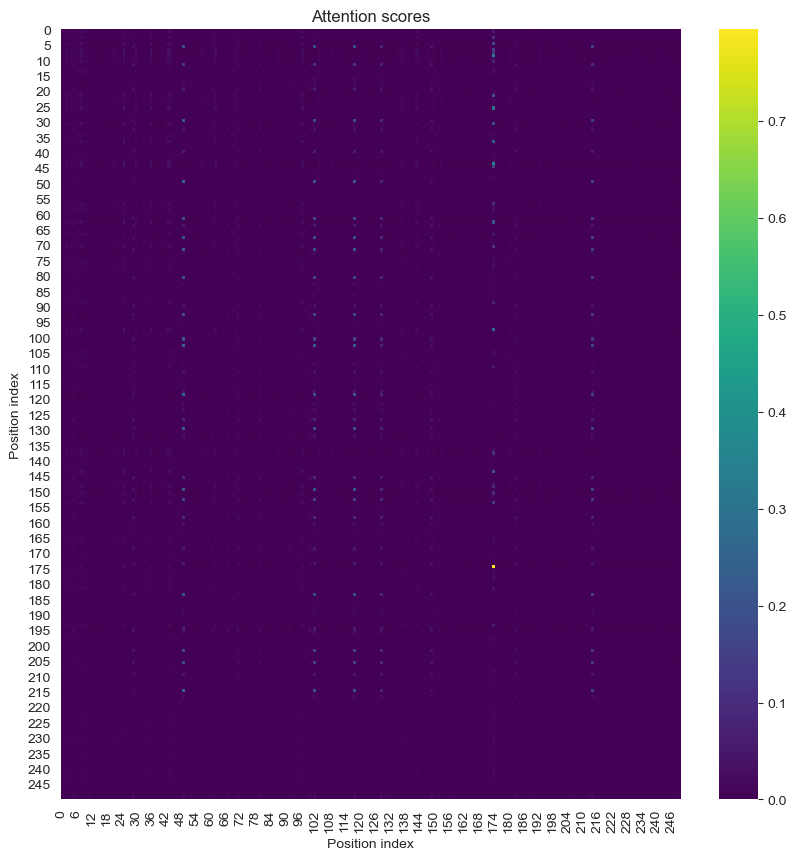

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(attention_scores, cmap='viridis')
plt.title('Attention scores')
plt.xlabel('Position index')
plt.ylabel('Position index')
plt.show()

The large sequence length makes the visualization of the above heatmap quite difficult; for better clarity, we focus at a smaller subsection of the sample review from the beginning. 

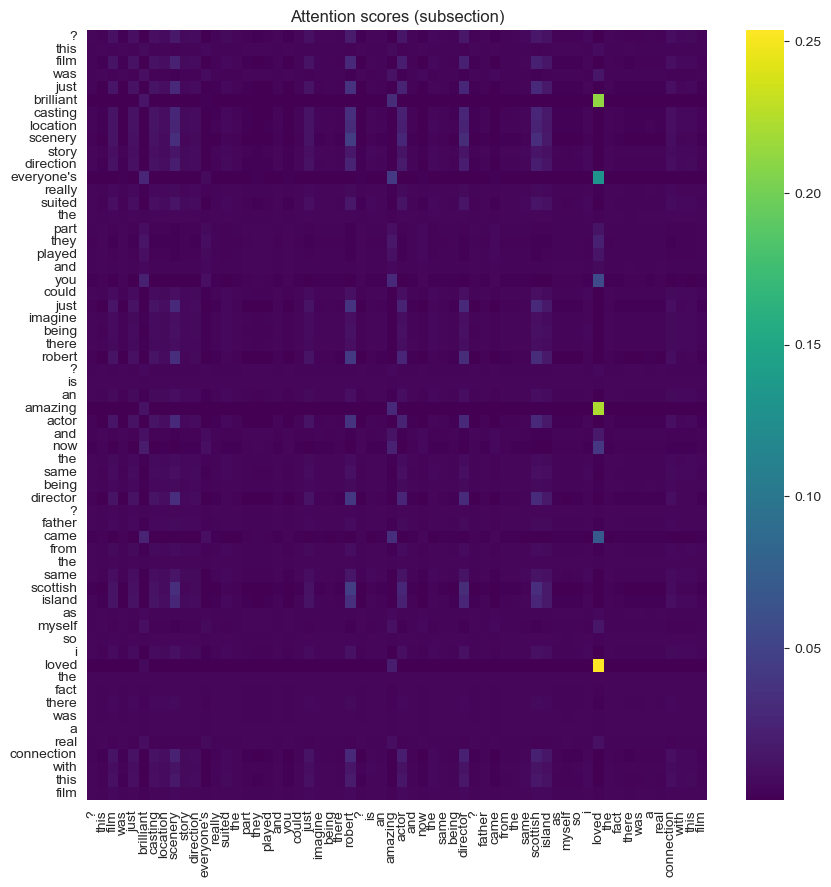

In [13]:
sub_length = 60  # Adjust the length of the subsection as needed
sub_scores = attention_scores[:sub_length, :sub_length]

# Plot the attention scores for the subsection
plt.figure(figsize=(10, 10))
sns.heatmap(sub_scores, 
            cmap='viridis',
            xticklabels=[index_to_word.get(i-3, '?') for i in sample_input[0][:sub_length]],
            yticklabels=[index_to_word.get(i-3, '?') for i in sample_input[0][:sub_length]])
plt.title('Attention scores (subsection)')
plt.show()


Note e.g. that the word "loved" in the review exhibits large attention scores with the earlier words "amazing" and "brilliant" in the same sequence. 